In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def masstestAlt(mylist, locmodel):
    predicts =  all_predicts[mylist]
    reals = all_normals[mylist]
    imgimg = locmodel.predict([predicts])
    r0 =  np.concatenate(predicts, axis=1)
    r1 =  np.concatenate(imgimg, axis=1)
    r2 =  np.concatenate(reals, axis=1)
    finalimage = np.concatenate([r0, r1, r2], axis=0)
    return finalimage

In [6]:
locloc = "BigData" 
namename = "\TestBigPastel"
all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
all_predicts = np.load("SharpenInputs//small_blurry_predictions.npy")

In [7]:
print(all_normals.shape)
print(all_predicts.shape)

(6840, 64, 64, 3)
(6840, 64, 64, 3)


In [8]:
image_size = (64,64,3)

In [27]:
def ConvBlock(inputs, filters=64):
    conv1 = keras.layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = keras.layers.BatchNormalization()(conv1)
    act1 = keras.layers.ReLU()(batch_norm1)
    conv2 = keras.layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = keras.layers.BatchNormalization()(conv2)
    act2 = keras.layers.ReLU()(batch_norm2)
    return act2
def encoder(inputs, filters=64):
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = keras.layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1
def decoder(inputs, skip, filters=64):
    Upsample = keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = keras.layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out
def get_U_Net(image_size):
    inputs = keras.layers.Input(image_size)
    
    skip1, encoder_1 = encoder(inputs, 24)
    skip2, encoder_2 = encoder(encoder_1, 24*2)
    skip3, encoder_3 = encoder(encoder_2, 24*4)
    #skip4, encoder_4 = encoder(encoder_3, 24*8)
    
    conv_block = ConvBlock(encoder_3, 24*8)
    dropout_block = keras.layers.Dropout(0.3)(conv_block)
    
    #decoder_1 = decoder(conv_block, skip4, 24*8)
    decoder_2 = decoder(dropout_block, skip3, 24*4)
    decoder_3 = decoder(decoder_2, skip2, 24*2)
    decoder_4 = decoder(decoder_3, skip1, 24)
    
    outputs = keras.layers.Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_4)
    
    model = keras.models.Model(inputs, outputs)
    return model

In [28]:
model = get_U_Net(image_size)
model.summary()
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00004)
model.compile(optimizer=g_optimizer_image, loss='mse')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_60 (Conv2D)             (None, 64, 64, 24)   672         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_56 (BatchN  (None, 64, 64, 24)  96          ['conv2d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_56 (ReLU)                (None, 64, 64, 24)   0           ['batch_normalization_56[0]

In [35]:
model.fit(all_predicts, all_normals, epochs=5)

Epoch 1/5
214/214 [==============================] - 8s 35ms/step - loss: 0.0037
Epoch 2/5
214/214 [==============================] - 7s 35ms/step - loss: 0.0035
Epoch 3/5
214/214 [==============================] - 7s 35ms/step - loss: 0.0033
Epoch 4/5
214/214 [==============================] - 8s 36ms/step - loss: 0.0032
Epoch 5/5
214/214 [==============================] - 7s 35ms/step - loss: 0.0030


1/1 [==============================] - 0s 33ms/step
(384, 768, 3)
Сверху вниз: Ввод // Предсказание // Реальность


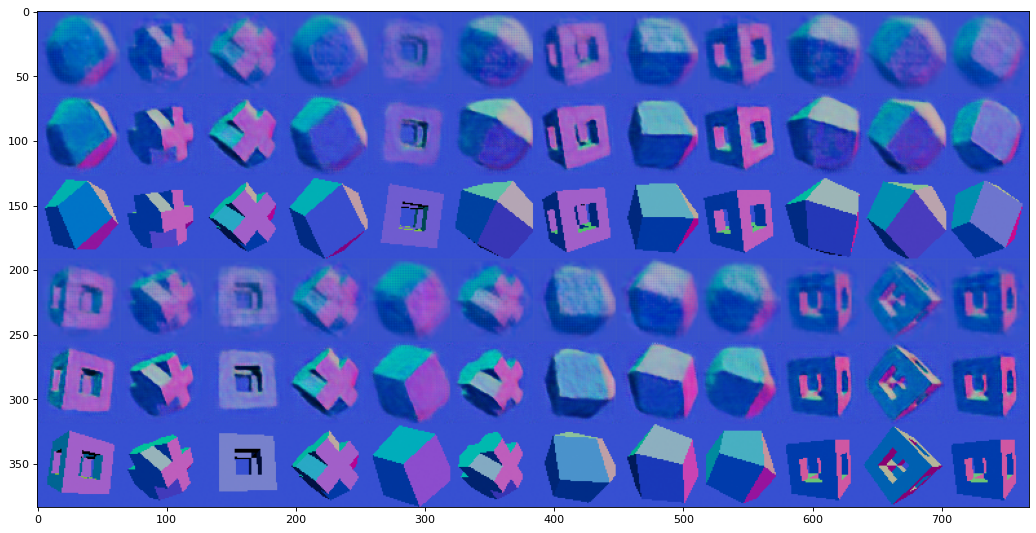

In [36]:
toinset = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([250, 750, 1250, 1750, 2250, 2750, 3250, 3750, 4250, 4750, 5250, 5750])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
print(bigpicture.shape)
plt.figure(figsize=(16, 12), dpi=80)
print("Сверху вниз: Ввод // Предсказание // Реальность")
plt.imshow(bigpicture.astype("float32").clip(0,1))

In [39]:
model.evaluate(test_inputs, test_normals) 

32/32 [==============================] - 1s 19ms/step - loss: 0.0028


0.002825838513672352

1/1 [==============================] - 0s 23ms/step


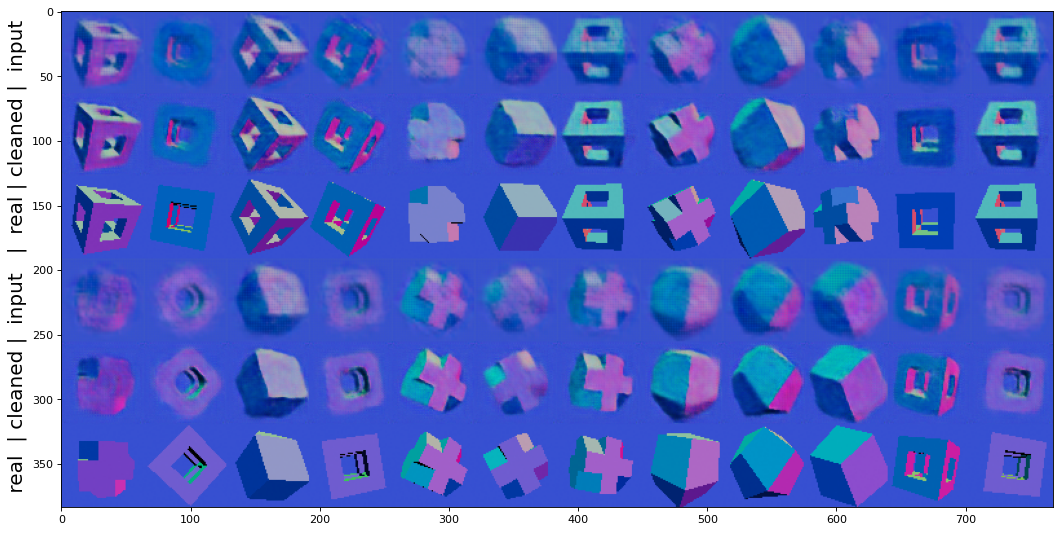

In [54]:
test_predictions = model.predict(test_inputs_visual)

r0 =  np.concatenate(test_inputs_visual[0:12], axis=1)
r1 =  np.concatenate(test_normals_visual[0:12], axis=1)
r2 =  np.concatenate(test_predictions[0:12], axis=1)
r4 =  np.concatenate(test_inputs_visual[12:24], axis=1)
r5 =  np.concatenate(test_normals_visual[12:24], axis=1)
r6 =  np.concatenate(test_predictions[12:24], axis=1)
finalimage = np.concatenate([r0,  r2, r1, r4, r6, r5], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel(" real  | cleaned |  input   |  real | cleaned |  input", fontsize=18)
plt.imshow(finalimage.clip(0,1))

In [45]:
#model.save("good_smoothie.keras")
# вай-вай, работает хорошо, чистит отлично. Картинки очень четкие.

In [37]:
locloc2 = "BigData" 
namename2 = "\TrainBigPastel"
all_test_normals = np.load(locloc2 + namename2 + 'Normals.npy')
test_normals = all_test_normals[0:1000]
test_normals_visual = all_test_normals[1000:1024]
del all_test_normals;
all_test_inputs = np.load("SharpenInputs//big_blurry_predictions.npy")
test_inputs= all_test_inputs[0:1000]
test_inputs_visual = all_test_inputs[1000:1024]
del all_test_inputs;